In [1]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("online_retail_rfm.csv")
df.head()

CustomerID  Recency  Frequency  Monetary
0       12347     4084          1    711.79
1       12348     4075          1    892.80
2       12370     4074          2   1868.02
3       12377     4071          1   1001.52
4       12386     4083          1    258.90

In [3]:
df.Recency = df.Recency - 4000 #for scaling purpose

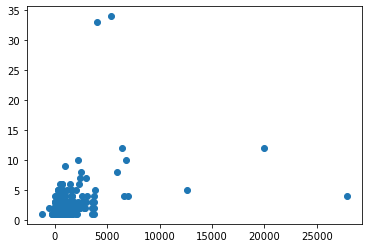

In [4]:
plt.scatter(df.Monetary, df.Frequency)

<AxesSubplot:xlabel='Recency', ylabel='Density'>

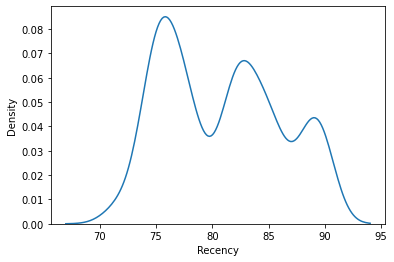

In [5]:
sns.kdeplot(df.Recency)

<AxesSubplot:xlabel='Frequency', ylabel='Density'>

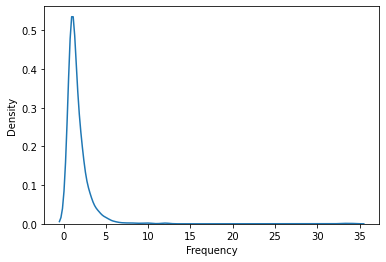

In [6]:
sns.kdeplot(df.Frequency)

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

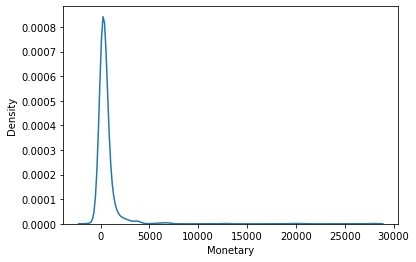

In [7]:
sns.kdeplot(df.Monetary)

In [8]:
km = KMeans(n_clusters=3)

In [9]:
y_pred = km.fit_predict(df[['Monetary', 'Recency', 'Frequency']])

In [10]:
df['Cluster'] = y_pred

In [11]:
df.Cluster.value_counts()

0    872
2     35
1      2
Name: Cluster, dtype: int64

## 3D Scatter Plot

In [12]:
centroids = km.cluster_centers_

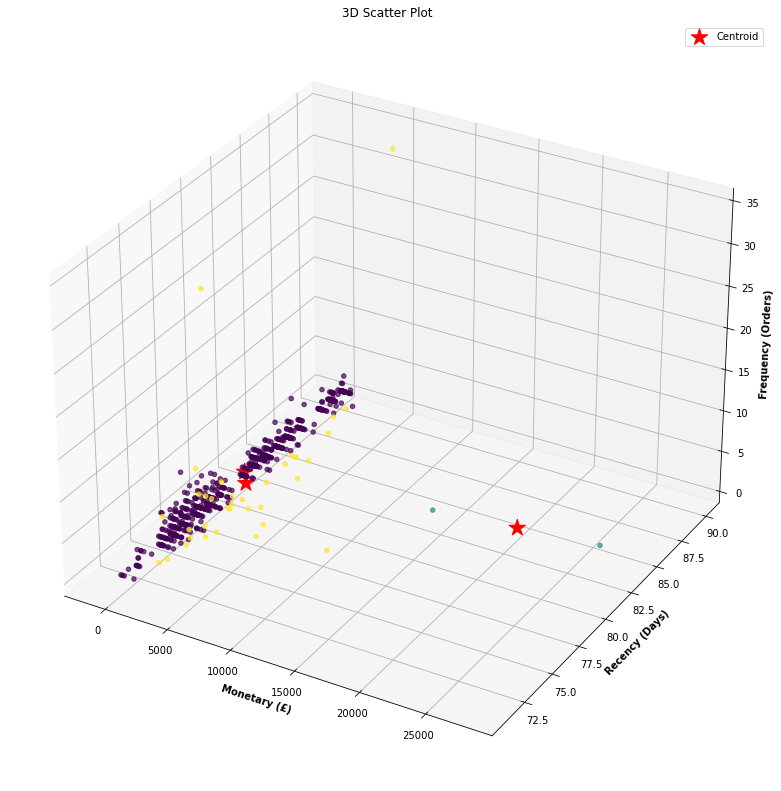

In [13]:
fig = plt.figure(figsize = (20, 14))
ax = plt.axes(projection = '3d')
ax.scatter3D(xs = df.Monetary, ys =  df.Recency, zs = df.Frequency, alpha = 0.7, c = df.Cluster)
ax.scatter3D(centroids[:,0], centroids[:,1], centroids[:,2],
             s = 300,
             alpha = 1,
             c = 'red',
             marker='*',
             label='Centroid')

plt.title('3D Scatter Plot')
ax.set_xlabel('Monetary (£)', fontweight = 'bold')
ax.set_ylabel('Recency (Days)', fontweight = 'bold')
ax.set_zlabel('Frequency (Orders)', fontweight = 'bold')
plt.legend()

plt.show()

## Scaling

In [14]:
scaler = MinMaxScaler()

scaler.fit(df[['Monetary']])
df['Monetary_scaled'] = scaler.transform(df[['Monetary']])

scaler.fit(df[['Recency']])
df['Recency_scaled'] = scaler.transform(df[['Recency']])

scaler.fit(df[['Frequency']])
df['Frequency_scaled'] = scaler.transform(df[['Frequency']])

In [15]:
km = KMeans(n_clusters=3)
y_pred_scaled = km.fit_predict(df.iloc[:,5:])

In [16]:
df['Cluster_scaled'] = y_pred_scaled

In [17]:
df.Cluster_scaled.value_counts()

1    424
0    295
2    190
Name: Cluster_scaled, dtype: int64

In [18]:
centroids_scaled = km.cluster_centers_

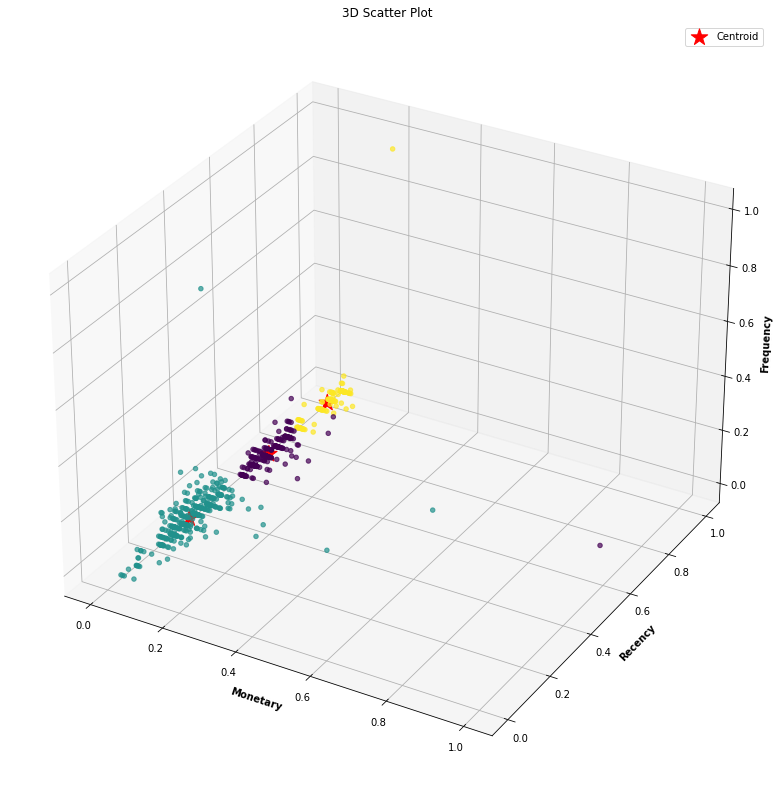

In [19]:
fig = plt.figure(figsize = (20, 14))
ax = plt.axes(projection = '3d')
ax.scatter3D(xs = df.Monetary_scaled, ys = df.Recency_scaled, zs = df.Frequency_scaled, alpha = 0.7, c = df.Cluster_scaled)
ax.scatter3D(centroids_scaled[:,0], centroids_scaled[:,1], centroids_scaled[:,2],
             s = 300,
             alpha = 1,
             c = 'red',
             marker='*',
             label='Centroid')

plt.title('3D Scatter Plot')
ax.set_xlabel('Monetary', fontweight = 'bold')
ax.set_ylabel('Recency', fontweight = 'bold')
ax.set_zlabel('Frequency', fontweight = 'bold')
plt.legend()

plt.show()

## The Elbow Method for Optimal Value of K

In [20]:
k_rng = range(1,10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df[['Monetary_scaled', 'Recency_scaled', 'Frequency_scaled']])
    sse.append(km.inertia_)

In [21]:
sse

[74.07057448178291,
 20.822476015015123,
 11.155012752139637,
 8.810946020974267,
 7.022958063569161,
 5.248620268372731,
 4.171873147815875,
 3.5196371517786162,
 3.1153376410470375]

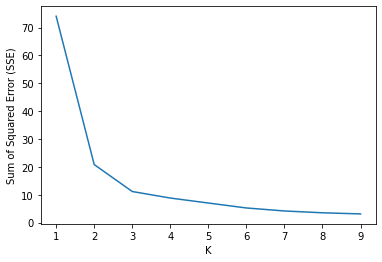

In [22]:
plt.xlabel('K')
plt.ylabel('Sum of Squared Error (SSE)')
plt.plot(k_rng,sse)

## Diving into the Clusters

In [23]:
df2 = df[['CustomerID','Recency','Frequency','Monetary','Cluster_scaled']]
df2=df2.rename(columns = {'Cluster_scaled':'Cluster'})

#### Average Recency by Cluster

In [24]:
avg_rec = pd.DataFrame(df2.groupby('Cluster').Recency.mean()).reset_index()
avg_rec

Cluster    Recency
0        0  82.979661
1        1  75.924528
2        2  88.473684

#### Average Frequency by Cluster

In [25]:
avg_freq = pd.DataFrame(df2.groupby('Cluster').Frequency.mean()).reset_index()
avg_freq

Cluster  Frequency
0        0   1.413559
1        1   2.089623
2        2   1.331579

#### Average Monetary by Cluster

In [26]:
avg_mon = pd.DataFrame(df2.groupby('Cluster').Monetary.mean()).reset_index()
avg_mon

Cluster    Monetary
0        0  512.011220
1        1  699.104575
2        2  344.554105

### Bar Charts

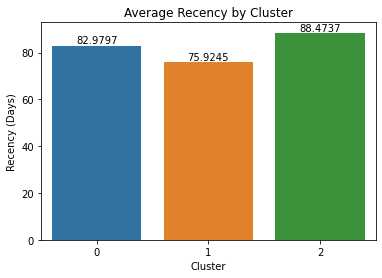

In [27]:
ax = sns.barplot(x='Cluster', y='Recency', data=avg_rec)
ax.bar_label(ax.containers[0])
ax.set_title('Average Recency by Cluster')
ax.set_ylabel('Recency (Days)')
plt.show()

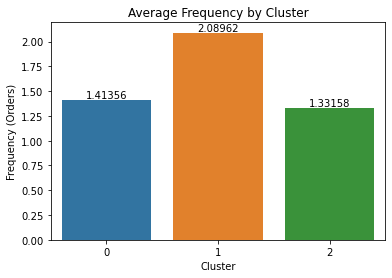

In [28]:
ax = sns.barplot(x='Cluster', y='Frequency', data=avg_freq)
ax.bar_label(ax.containers[0])
ax.set_title('Average Frequency by Cluster')
ax.set_ylabel('Frequency (Orders)')
plt.show()

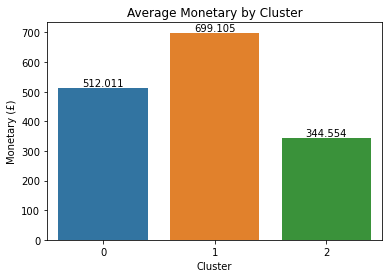

In [29]:
ax = sns.barplot(x='Cluster', y='Monetary', data=avg_mon)
ax.bar_label(ax.containers[0])
ax.set_title('Average Monetary by Cluster')
ax.set_ylabel('Monetary (£)')
plt.show()

## Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [31]:
clf = RandomForestClassifier()

In [32]:
X = df2.iloc[:,1:4]
y = df2.Cluster

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [34]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [35]:
cf_matrix = confusion_matrix(y_test, y_pred)

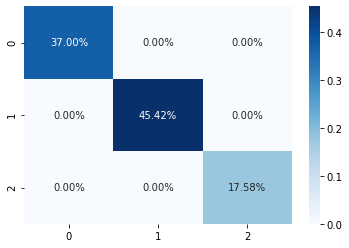

In [36]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

### Merging with the Original Dataset

In [37]:
df_clusters = df2[['CustomerID', 'Cluster']]

In [38]:
df_clusters

CustomerID  Cluster
0         12347        0
1         12348        1
2         12370        1
3         12377        1
4         12386        0
..          ...      ...
904       18245        1
905       18256        1
906       18259        0
907       18260        1
908       18269        1

[909 rows x 2 columns]

In [39]:
df_products = pd.read_csv('online_retail_products.csv')

In [40]:
df_products.head()

CustomerID StockCode                     Description  Quantity  UnitPrice
0       12347     20780       BLACK EAR MUFF HEADPHONES        12       4.65
1       12347     20782  CAMOUFLAGE EAR MUFF HEADPHONES         6       5.49
2       12347     21064           BOOM BOX SPEAKER BOYS         6       5.95
3       12347     21171            BATHROOM METAL SIGN         12       1.45
4       12347     21731   RED TOADSTOOL LED NIGHT LIGHT        12       1.65

In [41]:
df_merged = pd.merge(df_products, df_clusters, how = 'left', on = 'CustomerID')

In [42]:
df_merged.head()

CustomerID StockCode                     Description  Quantity  UnitPrice  \
0       12347     20780       BLACK EAR MUFF HEADPHONES        12       4.65   
1       12347     20782  CAMOUFLAGE EAR MUFF HEADPHONES         6       5.49   
2       12347     21064           BOOM BOX SPEAKER BOYS         6       5.95   
3       12347     21171            BATHROOM METAL SIGN         12       1.45   
4       12347     21731   RED TOADSTOOL LED NIGHT LIGHT        12       1.65   

   Cluster  
0        0  
1        0  
2        0  
3        0  
4        0

In [55]:
df_merged.sort_values('Quantity', ascending=False).groupby(['Cluster']).head(5).reset_index(drop=True)

CustomerID StockCode                      Description  Quantity  \
0        12348     21981      PACK OF 12 WOODLAND TISSUES       144   
1        12348     21982          PACK OF 12 SUKI TISSUES       144   
2        12348     84991      60 TEATIME FAIRY CAKE CASES       120   
3        12348     22952  60 CAKE CASES VINTAGE CHRISTMAS       120   
4        12348     21213      PACK OF 72 SKULL CAKE CASES       120   
5        12386     22915    ASSORTED BOTTLE TOP  MAGNETS        120   
6        12429     22951  60 CAKE CASES DOLLY GIRL DESIGN       120   
7        12557     20728              LUNCH BAG CARS BLUE       100   
8        12557     22384          LUNCH BAG PINK POLKADOT       100   
9        12433     22444    GROW YOUR OWN PLANT IN A CAN         96   
10       12433     22197             SMALL POPCORN HOLDER        72   
11       12433     22197             SMALL POPCORN HOLDER        72   
12       12557     20725          LUNCH BAG RED RETROSPOT        70   
13       12557     22383          LUNCH BAG SUKI  DESIGN         70   
14       12557     20727          LUNCH BAG  BLACK SKULL.        60   

    UnitPrice  Cluster  
0        0.29        1  
1        0.29        1  
2        0.42        1  
3        0.42        1  
4        0.42        1  
5        0.36        0  
6        0.42        0  
7        1.45        2  
8        1.45        2  
9        1.06        0  
10       0.85        0  
11       0.85        0  
12       1.65        2  
13       1.65        2  
14       1.65        2

## Querying the Merged Dataset with SQLite3

In [45]:
import sqlite3

In [51]:
#connect to database
conn = sqlite3.connect("Database.db")
#store table in database:
df_merged.to_sql('df_merged_table', conn)

In [64]:
#read SQL Query out of database into pandas dataframe
sql_string = """WITH CTE AS (SELECT *, ROW_NUMBER() OVER(PARTITION BY Cluster ORDER BY QUANTITY DESC) RANK
                                FROM df_merged_table) SELECT * FROM CTE WHERE RANK <= 5"""

pd.read_sql(sql_string, conn)

index  CustomerID StockCode                         Description  Quantity  \
0     187       12386     22915       ASSORTED BOTTLE TOP  MAGNETS        120   
1     257       12429     22951     60 CAKE CASES DOLLY GIRL DESIGN       120   
2     343       12433     22444       GROW YOUR OWN PLANT IN A CAN         96   
3     336       12433     22197                SMALL POPCORN HOLDER        72   
4     337       12433     22197                SMALL POPCORN HOLDER        72   
5      37       12348     21981         PACK OF 12 WOODLAND TISSUES       144   
6      38       12348     21982             PACK OF 12 SUKI TISSUES       144   
7      33       12348     21213         PACK OF 72 SKULL CAKE CASES       120   
8      35       12348     21977  PACK OF 60 PINK PAISLEY CAKE CASES       120   
9      41       12348     22952     60 CAKE CASES VINTAGE CHRISTMAS       120   
10    663       12557     20728                 LUNCH BAG CARS BLUE       100   
11    665       12557     22384             LUNCH BAG PINK POLKADOT       100   
12    661       12557     20725             LUNCH BAG RED RETROSPOT        70   
13    664       12557     22383             LUNCH BAG SUKI  DESIGN         70   
14    662       12557     20727             LUNCH BAG  BLACK SKULL.        60   

    UnitPrice  Cluster  RANK  
0        0.36        0     1  
1        0.42        0     2  
2        1.06        0     3  
3        0.85        0     4  
4        0.85        0     5  
5        0.29        1     1  
6        0.29        1     2  
7        0.42        1     3  
8        0.42        1     4  
9        0.42        1     5  
10       1.45        2     1  
11       1.45        2     2  
12       1.65        2     3  
13       1.65        2     4  
14       1.65        2     5